In [1]:
import pytesseract
from PIL import Image

In [2]:
img_file = "images/postr_2.jpeg"

In [3]:
img = Image.open(img_file)

In [4]:
ocr_result = pytesseract.image_to_string(img)

In [5]:
print(ocr_result)

Witte
g PSA

“80% -




In [6]:
import cv2 as cv
from matplotlib import pyplot as plt

In [7]:
image_file = "images/postr_2.jpeg"
img = cv.imread(image_file)

In [8]:
#cv.imshow("original image", img)
#cv.waitKey(0)

In [9]:
'''def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    #what size does the fig need to be in the inches to fit the image?
    figsize = width/float(dpi), height/float(dpi)

    #create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize = figsize)
    ax = fig.add_axes([0,0,1,1])

    #hide spines, ticks, etc.
    ax.axis('off')

    #display the image
    ax.imshow(im_data, cmap = 'gray')

    plt.show()

'''
def display(im_path):
  dpi = 80
  im_data = plt.imread(im_path)
  try:
    # Attempt to unpack all three channels (height, width, depth)
    height, width, depth = im_data.shape
  except ValueError:
    # Handle grayscale images with only two channels
    height, width = im_data.shape
    depth = 1  # Assuming grayscale has one channel

  # Convert grayscale to 3-channel (optional)
  if depth == 1:
    im_data = cv.cvtColor(im_data, cv.COLOR_GRAY2BGR)

  # Calculate figure size
  figsize = width / float(dpi), height / float(dpi)

  # Create a figure and axes
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])

  # Hide spines, ticks, etc.
  ax.axis('off')

  # Display the image with appropriate colormap
  ax.imshow(im_data, cmap='gray' if depth == 1 else None)  # Use grayscale cmap for grayscale images

  plt.show()

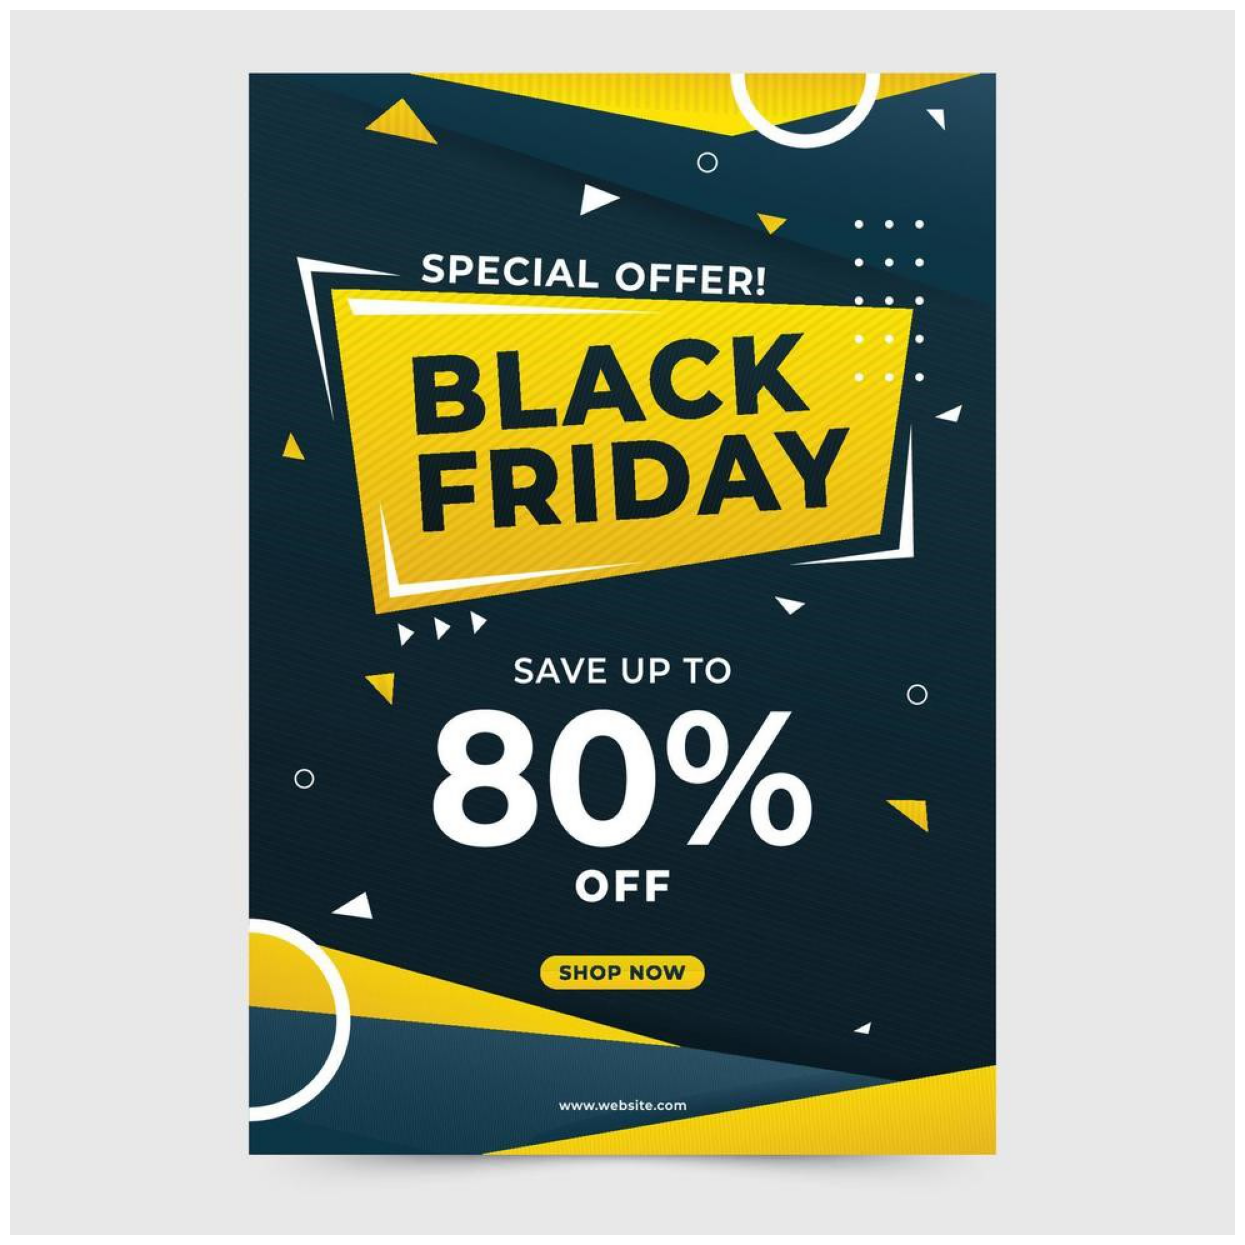

In [10]:
display(image_file)

In [11]:
inverted_image = cv.bitwise_not(img)
cv.imwrite("temp/postr_2.jpeg",inverted_image)

True

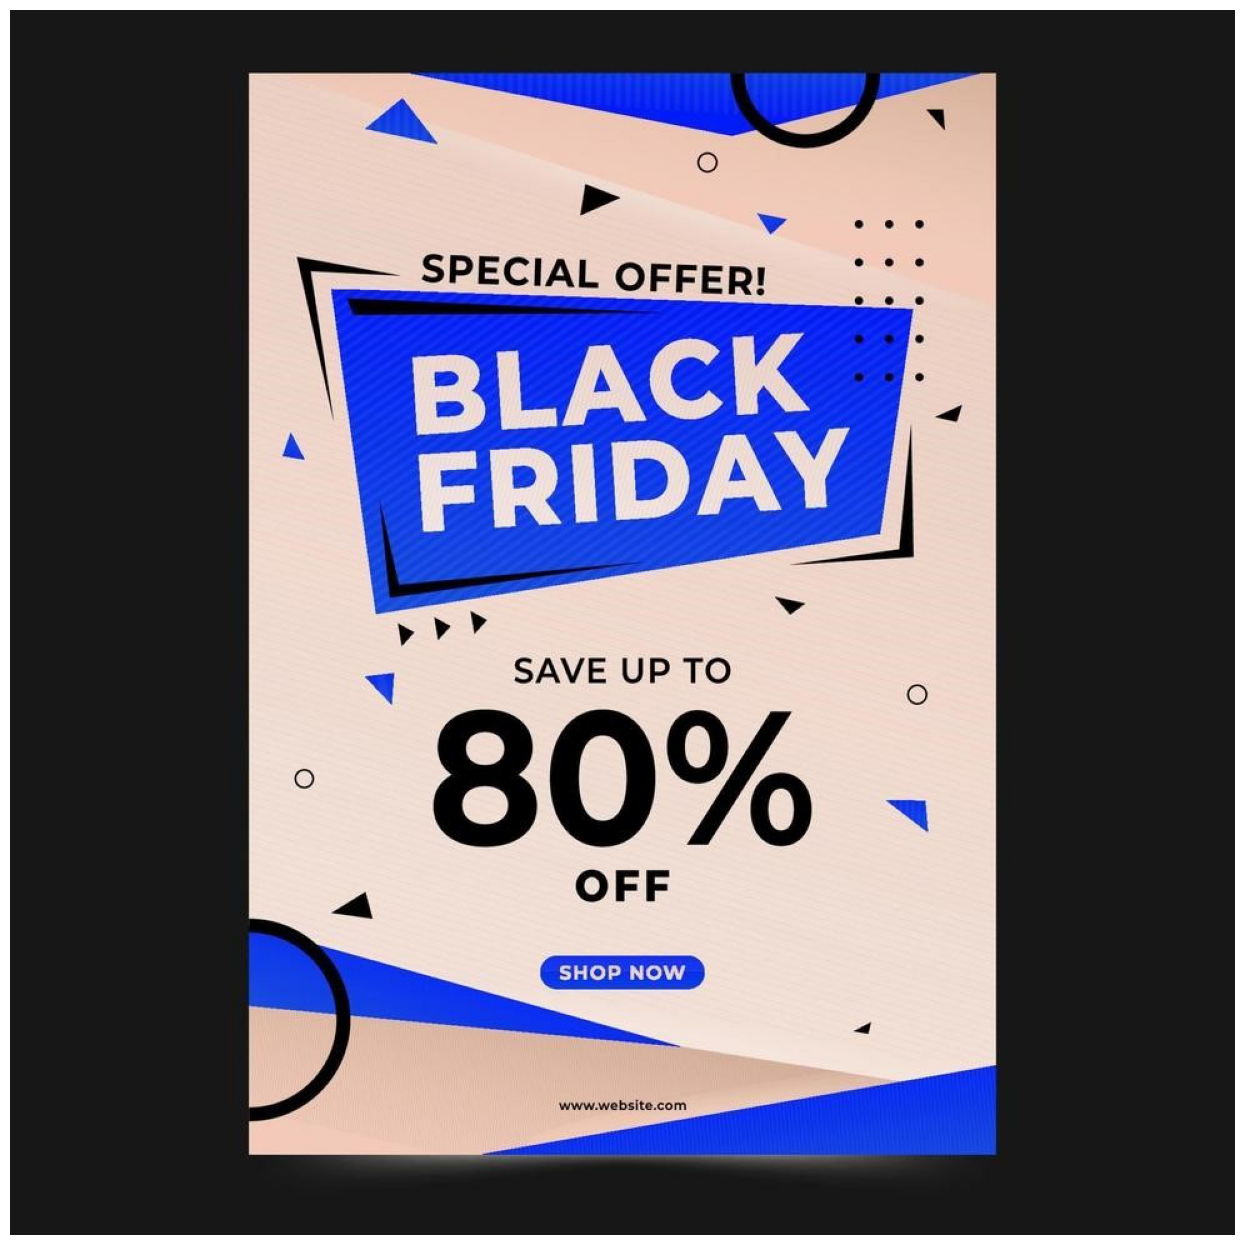

In [12]:
display("temp/postr_2.jpeg")

In [13]:
def grayscale(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [14]:
gray_image = grayscale(img)
cv.imwrite("temp/gray_postr_2.jpeg", gray_image)

True

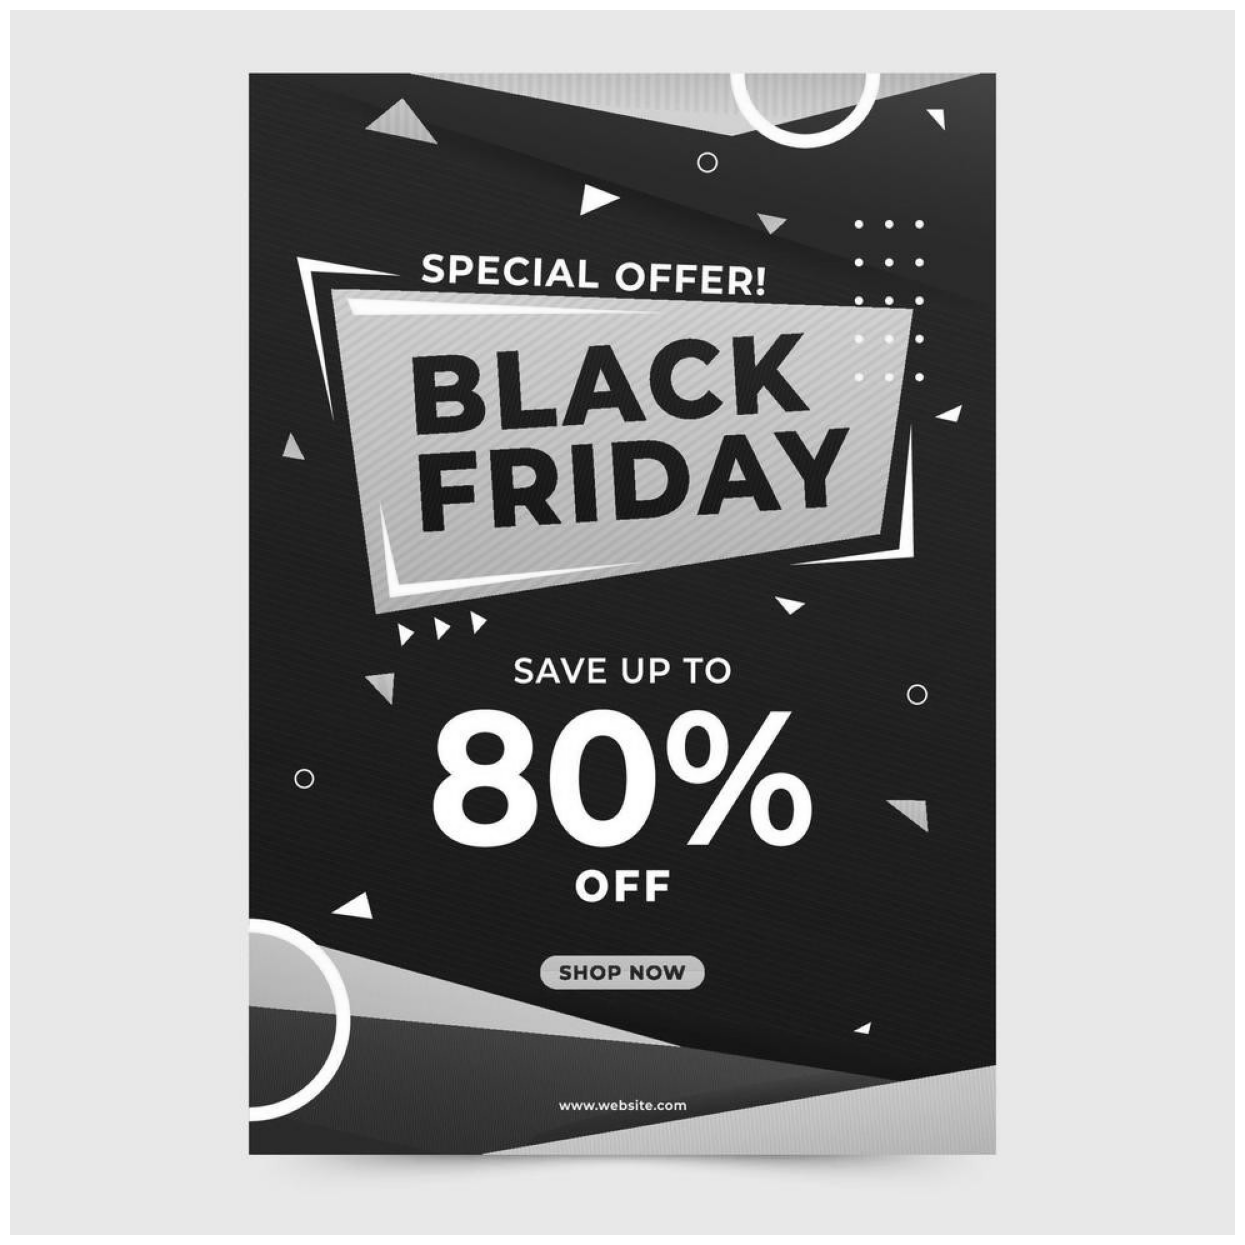

In [15]:
display("temp/gray_postr_2.jpeg")

In [16]:
thresh, im_bw = cv.threshold(gray_image, 130, 255, cv.THRESH_BINARY)
cv.imwrite("temp/bw_postr_2.jpeg", im_bw)

True

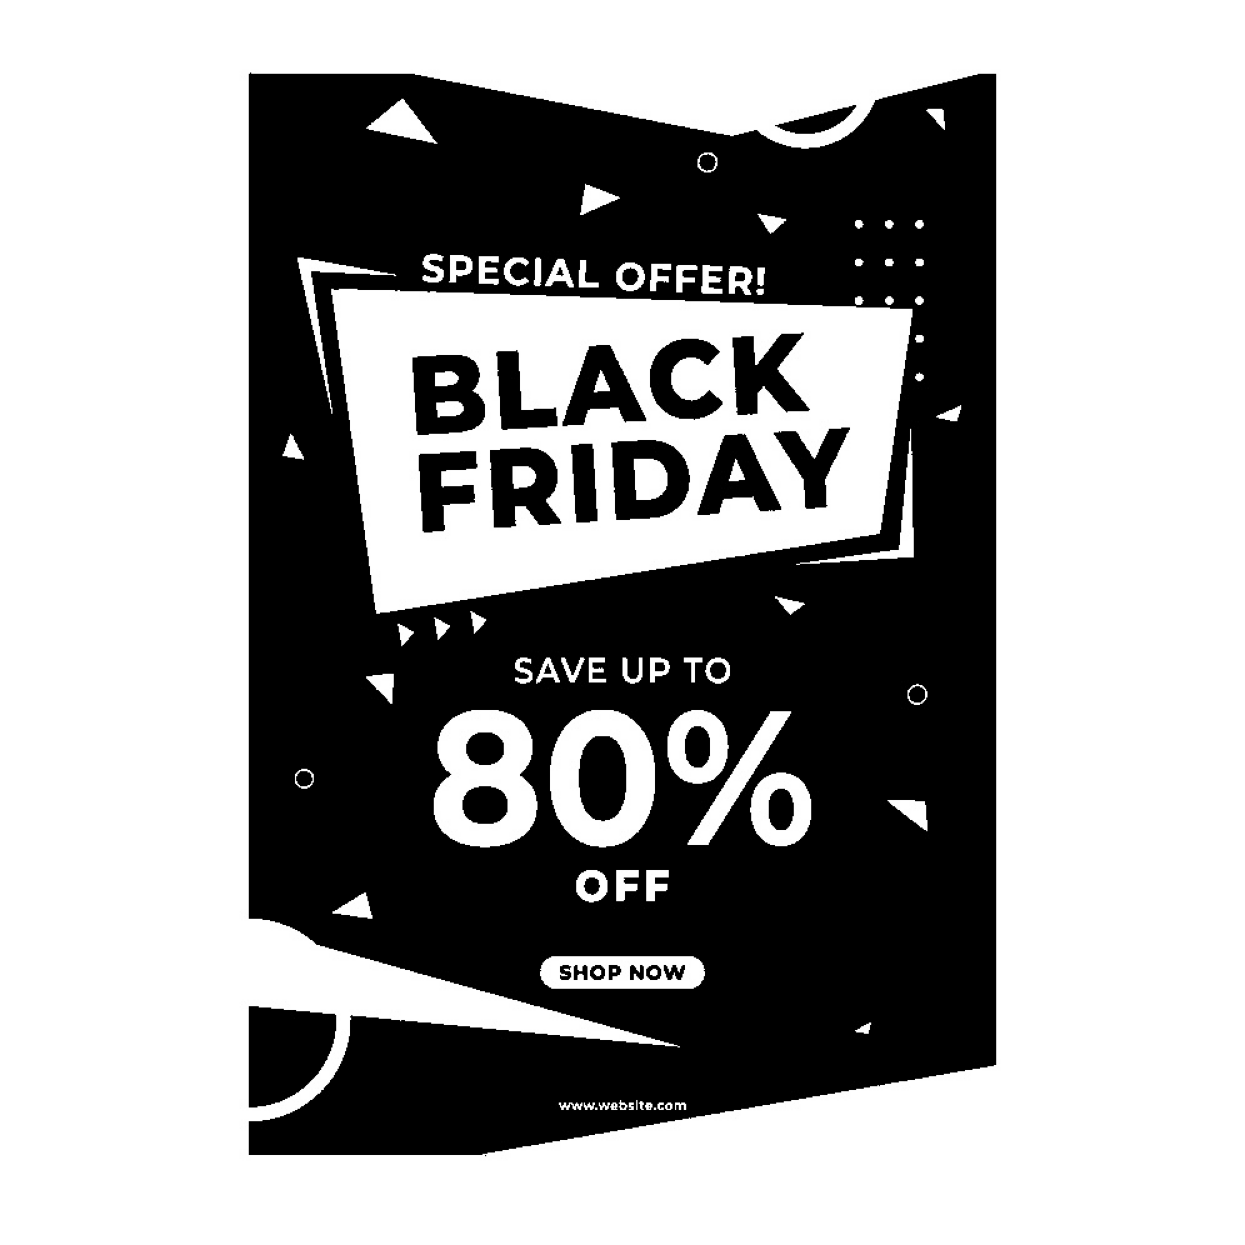

In [17]:
display("temp/bw_postr_2.jpeg")

In [18]:
'''def noise_removal(image):
    import numpy as np
    kernal = np.ones((1, 1), np.uint8)
    image = cv.dilate(image, kernel, iterations = 1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv.erode(image, kernel, iterations = 1)
    image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    image = cv.medialBlur(image, 3)
    return image

'''
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)  # Combine dilation and erosion
    image = cv.medianBlur(image, 3)  # Consider using a more efficient median filtering implementation
    return image

In [19]:
no_noise = noise_removal(im_bw)
cv.imwrite("temp/no_noise_postr_2.jpeg", no_noise)

True

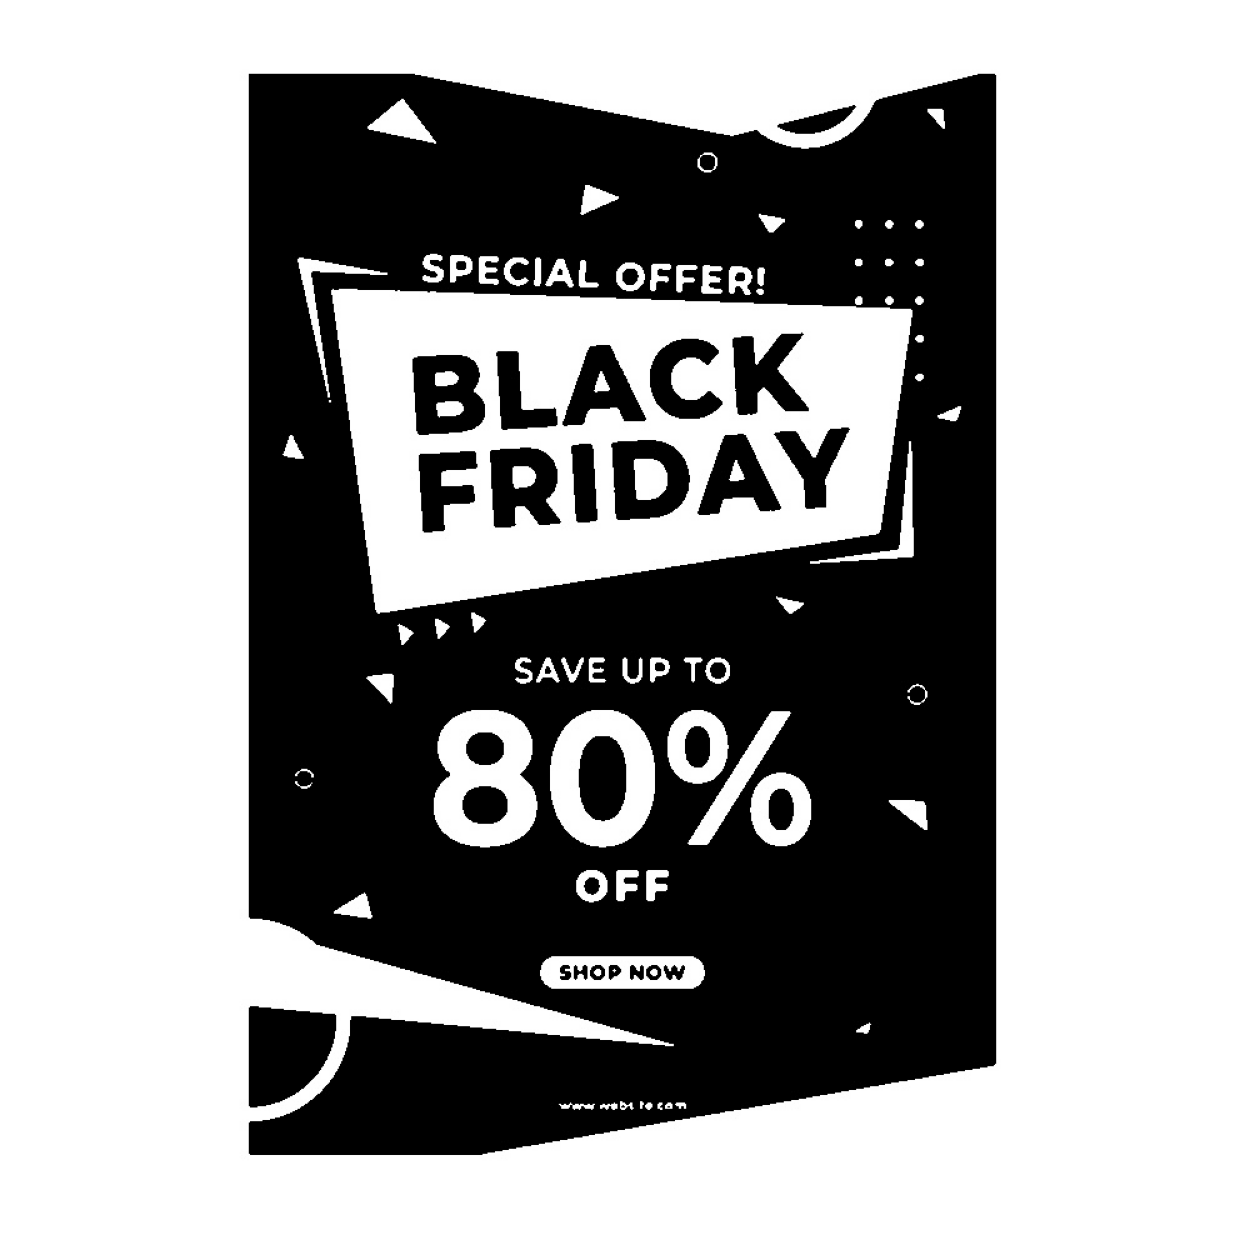

In [20]:
display("temp/no_noise_postr_2.jpeg")

In [21]:
def thin_font(image):
    import numpy as np
    image = cv.bitwise_not(image)
    kernel = np.ones((2,2), np.uint8)
    image = cv.erode(image, kernel, iterations = 1)
    image = cv.bitwise_not(image)
    return image

In [22]:
eroded_image = thin_font(no_noise)
cv.imwrite("temp/eroded_postr_2.jpeg", eroded_image)

True

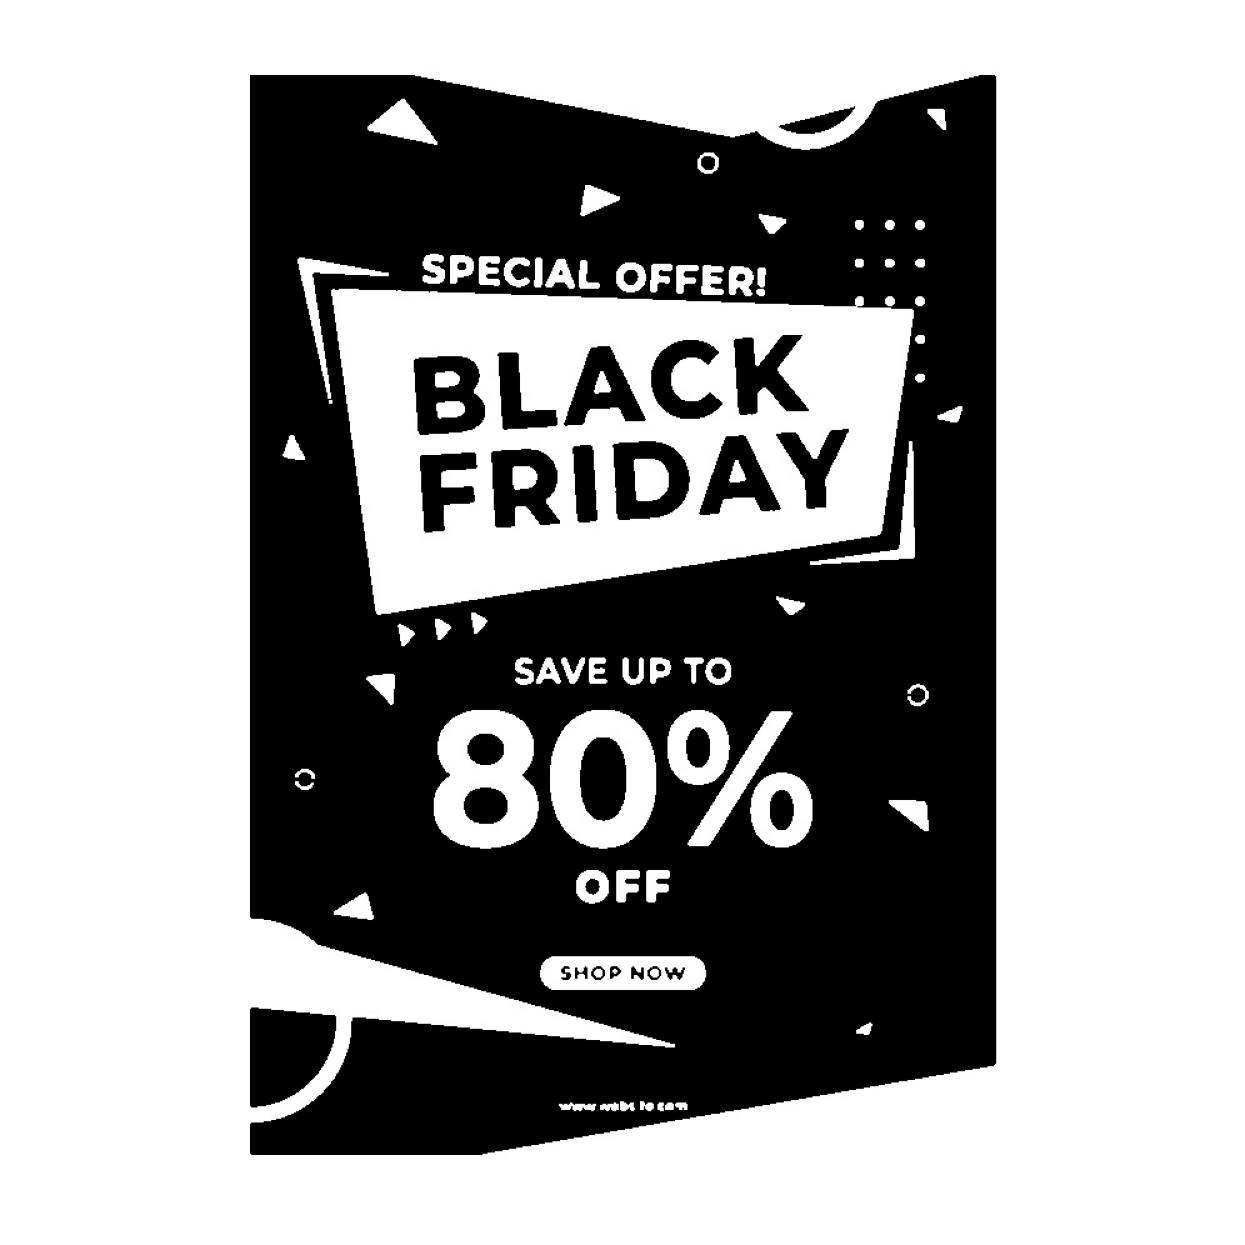

In [23]:
display("temp/eroded_postr_2.jpeg")

In [65]:
def thick_font(image):
    import numpy as np
    image = cv.bitwise_not(image)
    kernel = np.ones((2,2), np.uint8)
    image = cv.dilate(image, kernel, iterations = 1)
    image = cv.bitwise_not(image)
    return image

In [67]:
dilated_image = thick_font(no_noise)
cv.imwrite("temp/dilated_postr_2.jpeg", dilated_image)

True

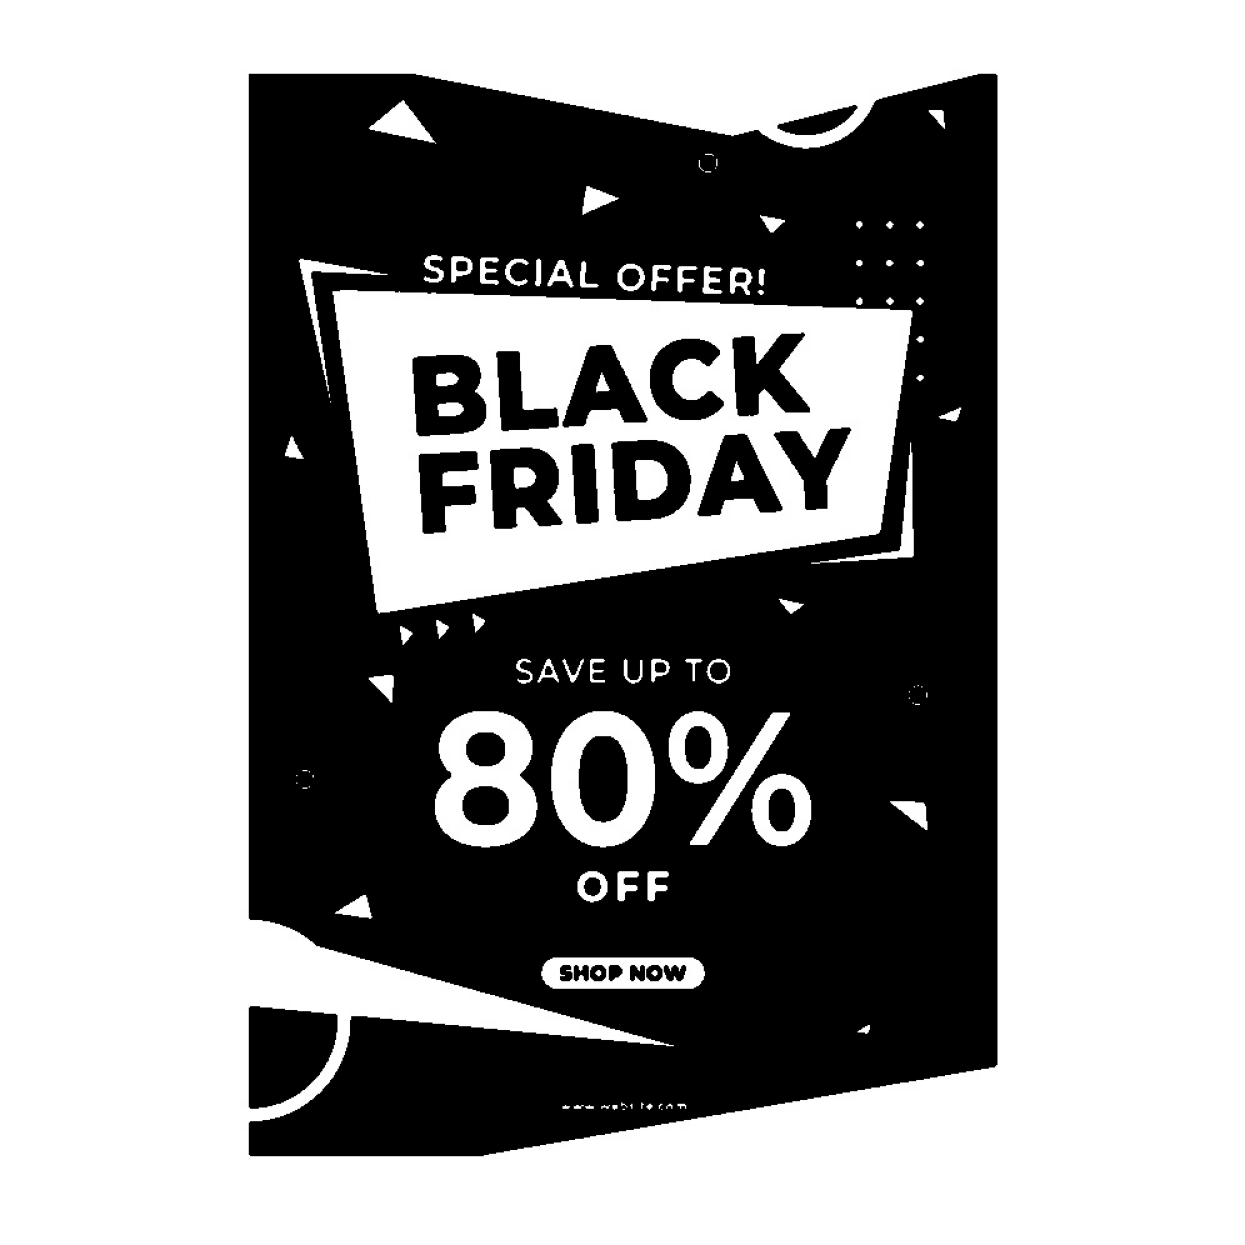

In [69]:
display("temp/dilated_postr_2.jpeg")

In [ ]:
#new = cv.imread("data/page_01_rotated.JPG")
#display("data/page_01_rotated.JPG")

In [180]:
'''
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv.cvtColor(newImage, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (9, 9), 0)
    thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (30, 5))
    dilate = cv.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv.findContours(dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv.contourArea, reverse = True)
    for c in contours:
        rect = cv.boundingRect(c)
        x,y,w,h = rect
        cv.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv.minAreaRect(largestContour)
    cv.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv.warpAffine(newImage, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    return newImage

'''

'\nimport numpy as np\n\ndef getSkewAngle(cvImage) -> float:\n    # Prep image, copy, convert to gray scale, blur, and threshold\n    newImage = cvImage.copy()\n    gray = cv.cvtColor(newImage, cv.COLOR_BGR2GRAY)\n    blur = cv.GaussianBlur(gray, (9, 9), 0)\n    thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]\n\n    # Apply dilate to merge text into meaningful lines/paragraphs.\n    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.\n    # But use smaller kernel on Y axis to separate between different blocks of text\n    kernel = cv.getStructuringElement(cv.MORPH_RECT, (30, 5))\n    dilate = cv.dilate(thresh, kernel, iterations=2)\n\n    # Find all contours\n    contours, hierarchy = cv.findContours(dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)\n    contours = sorted(contours, key = cv.contourArea, reverse = True)\n    for c in contours:\n        rect = cv.boundingRect(c)\n        x,y,w,h = rect\n        cv.recta

In [75]:
'''# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

'''

'# Deskew image\ndef deskew(cvImage):\n    angle = getSkewAngle(cvImage)\n    return rotateImage(cvImage, -1.0 * angle)\n\n'

In [77]:
'''fixed = deskew(new)
cv2.imwrite("temp/rotated_fixed.jpg", fixed)
'''

'fixed = deskew(new)\ncv2.imwrite("temp/rotated_fixed.jpg", fixed)\n'

In [79]:
#display("temp/rotated_fixed.jpg")

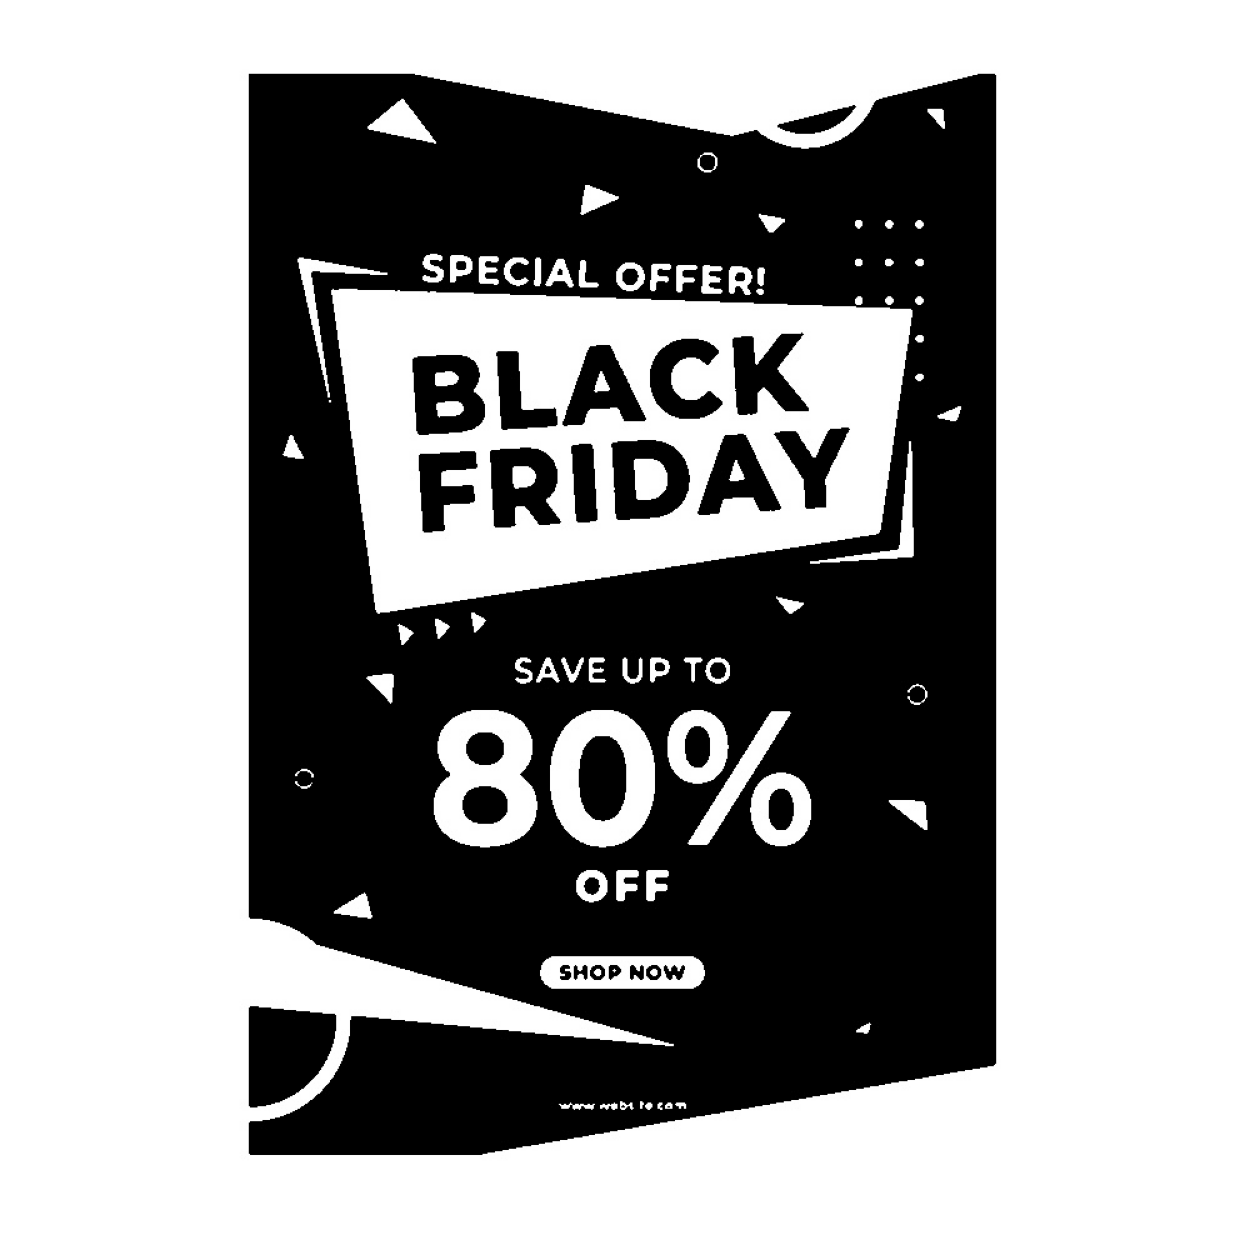

In [92]:
display("temp/no_noise_postr_2.jpeg")

In [94]:
def remove_borders(image):
    contours, heiarchy = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

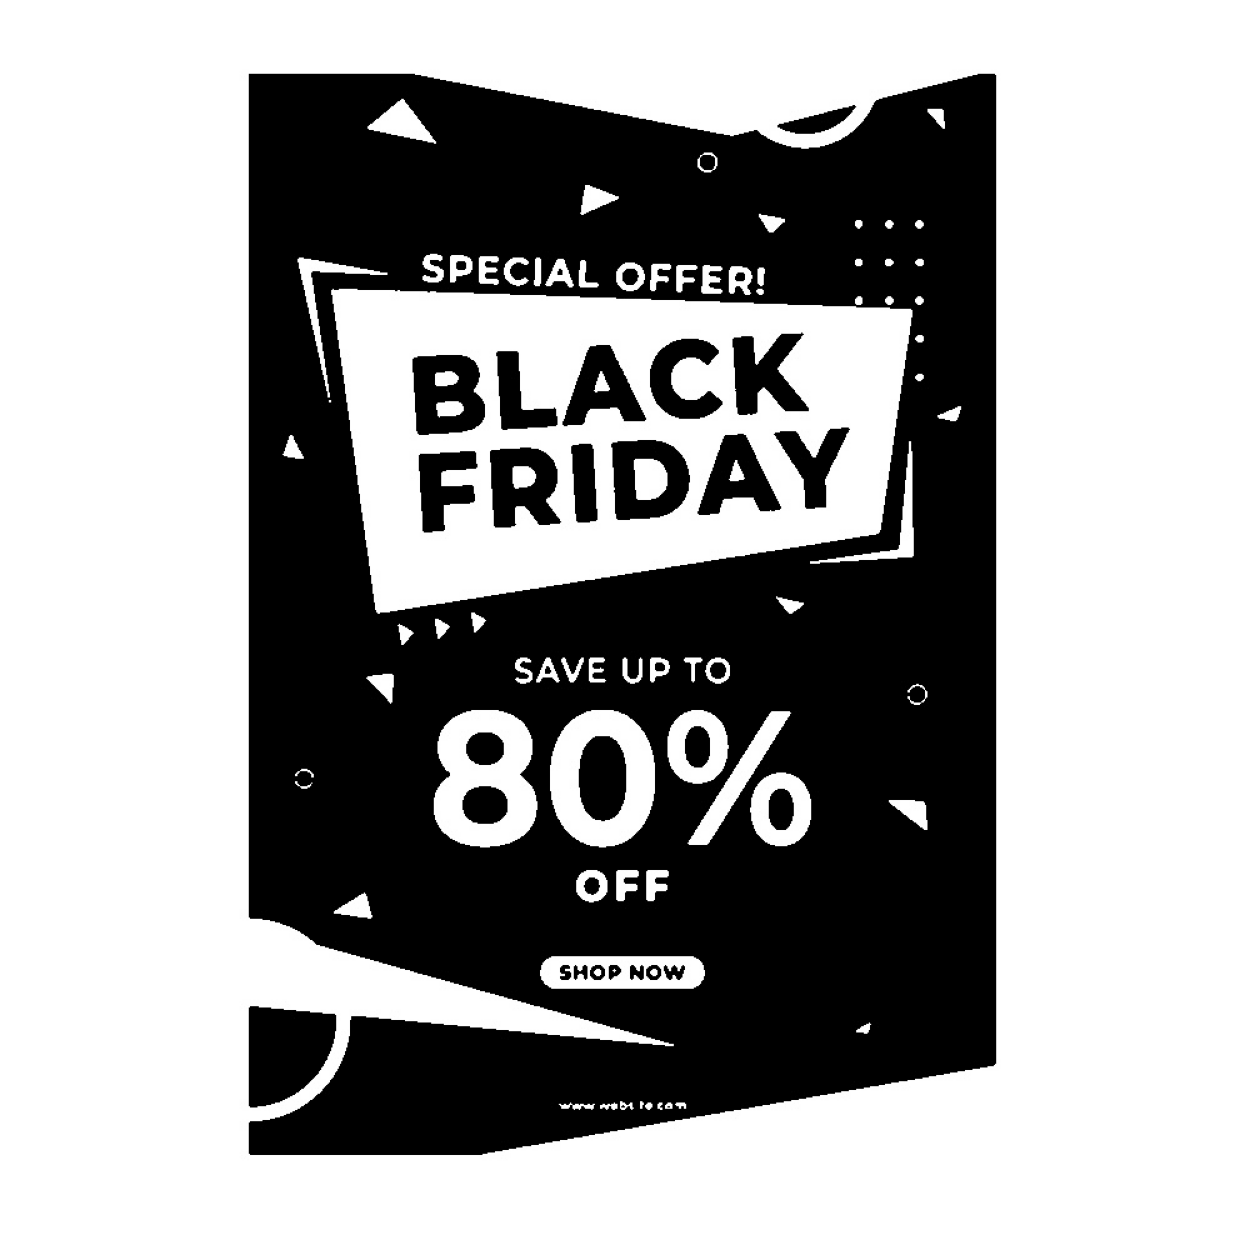

In [102]:
no_borders = remove_borders(no_noise)
cv.imwrite("temp/no_borders_postr_2.jpeg", no_borders)
display("temp/no_borders_postr_2.jpeg")

In [104]:
color = [255, 255, 255]
top, bottom, left, right = [150]*4

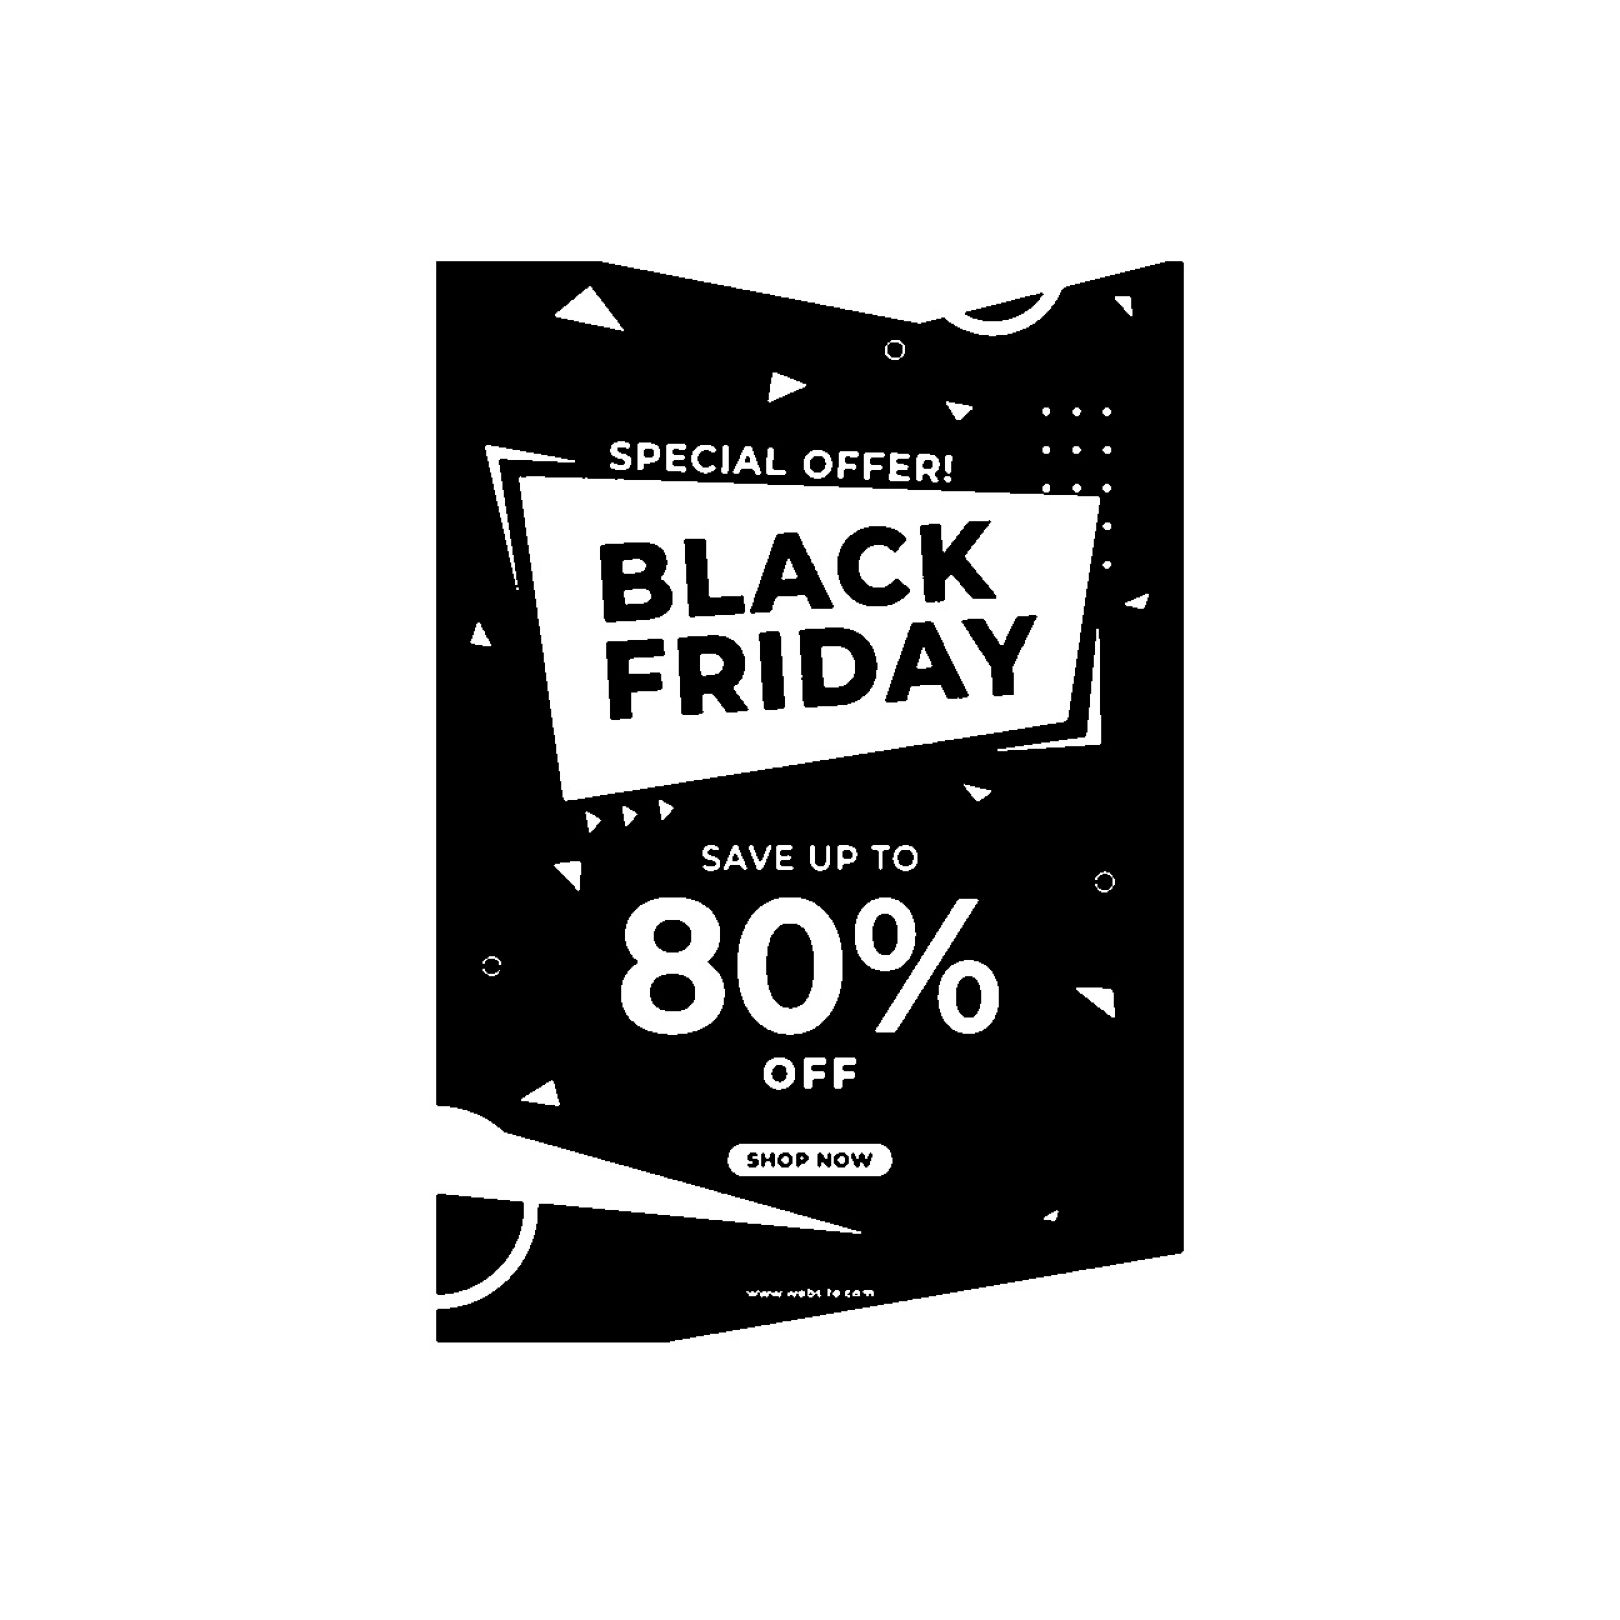

In [106]:
image_with_border = cv.copyMakeBorder(no_borders, top, bottom, left, right, cv.BORDER_CONSTANT, value=color)
cv.imwrite("temp/image_with_border_postr_2.jpeg", image_with_border)
display("temp/image_with_border_postr_2.jpeg")

In [166]:
img_file = "images/postr_2.jpeg"
no_noise = "temp/no_noise_postr_2.jpeg"

In [168]:
img1 = Image.open(img_file)

In [170]:
ocr_result1 = pytesseract.image_to_string(img1)

In [171]:
img2 = Image.open(no_noise)

In [172]:
ocr_result2 = pytesseract.image_to_string(img2)

In [173]:
print(ocr_result1)

Witte
g PSA

“80% -




In [174]:
print(ocr_result2)

a

PECIAL OFFER!

BLACK.
g PRtSAY

“80% .


